# Import libraries, load and transform data

In [28]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks
# - 'mlflow': MLflow is an open-source platform for managing the end-to-end machine learning lifecycle, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
%pip install -U -q evaluate pandas matplotlib scikit-learn imblearn torchvision transformers tf_keras datasets>=2.14.5 accelerate>=0.27

DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

2024-06-05 16:31:30.657464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 16:31:31.247164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path('/home/hssalazar/Dataset').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

190335 190335
(190335, 2)


In [5]:
df.head()

,image,label
0,/home/hssalazar/Dataset/Test/Fake/fake_0.jpg,Fake
1,/home/hssalazar/Dataset/Test/Fake/fake_1.jpg,Fake
2,/home/hssalazar/Dataset/Test/Fake/fake_10.jpg,Fake
3,/home/hssalazar/Dataset/Test/Fake/fake_100.jpg,Fake
4,/home/hssalazar/Dataset/Test/Fake/fake_1000.jpg,Fake


In [6]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [7]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(190402, 2)


In [8]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

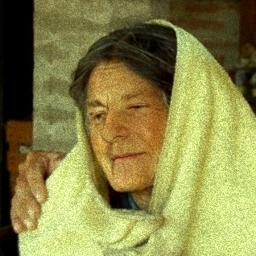

In [9]:
# Display the first image in the dataset
dataset[0]["image"]

In [10]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [11]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['Real', 'Fake'] # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [12]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [13]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [14]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [15]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [16]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.800194


In [17]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }


In [18]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 2

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
    
    # Specify the directory where training logs will be stored.
    logging_dir='./logs',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should not be reported.
    report_to="none"
)

In [19]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [20]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 0.023293351754546165,
 'eval_accuracy': 0.9922926432163444,
 'eval_runtime': 975.0579,
 'eval_samples_per_second': 78.109,
 'eval_steps_per_second': 1.221}

In [21]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.022690,0.992240
2,0.050900,0.022622,0.992280


TrainOutput(global_step=894, training_loss=0.05027046032933314, metrics={'train_runtime': 1414.5586, 'train_samples_per_second': 161.522, 'train_steps_per_second': 0.632, 'total_flos': 1.770552477112121e+19, 'train_loss': 0.05027046032933314, 'epoch': 2.0})

In [22]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.02262166328728199,
 'eval_accuracy': 0.9922795131366448,
 'eval_runtime': 235.562,
 'eval_samples_per_second': 323.316,
 'eval_steps_per_second': 5.056,
 'epoch': 2.0}

In [23]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.02262166328728199, 'test_accuracy': 0.9922795131366448, 'test_runtime': 214.3131, 'test_samples_per_second': 355.373, 'test_steps_per_second': 5.557}


Accuracy: 0.9923
F1 Score: 0.9923


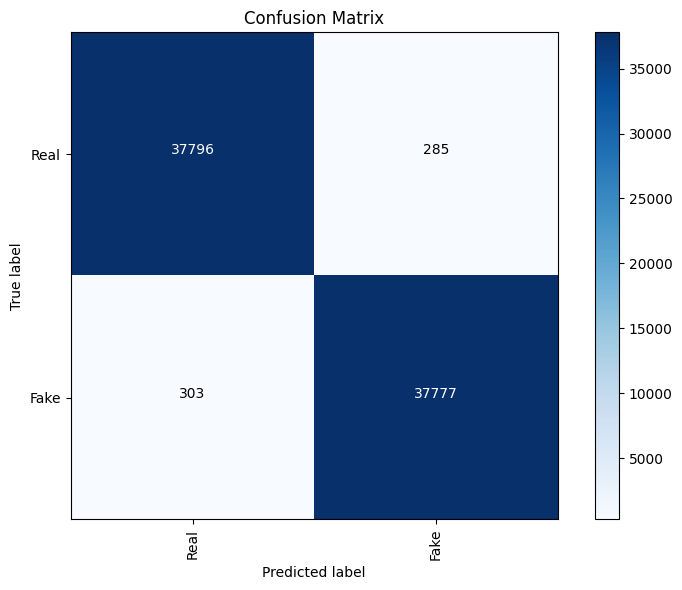


Classification report:

              precision    recall  f1-score   support

        Real     0.9920    0.9925    0.9923     38081
        Fake     0.9925    0.9920    0.9923     38080

    accuracy                         0.9923     76161
   macro avg     0.9923    0.9923    0.9923     76161
weighted avg     0.9923    0.9923    0.9923     76161



In [24]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [25]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [29]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

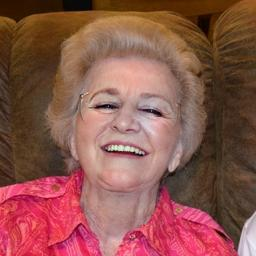

In [30]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [31]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'Fake', 'score': 0.9993144273757935},
 {'label': 'Real', 'score': 0.0006855605752207339}]

In [ ]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.
# It's used to retrieve the actual label associated with a test data point.
id2label[test_data[1]["label"]]